# Classifying Fashion-MNIST with Virtual Workers and Encrypted Models

In [1]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1024, shuffle=True)

Here we can see one of the images.

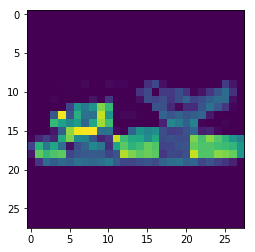

In [3]:
from matplotlib import pyplot as plt

image, label = next(iter(trainloader))
plt.imshow(image[0].view([28,28]))
plt.show()

## Building the network

Here you should define your network. As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. You should include at least one hidden layer. We suggest you use ReLU activations for the layers and to return the logits or log-softmax from the forward pass. It's up to you how many layers you add and the size of those layers.

In [4]:
from torch import nn, optim
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.h1 = nn.Linear(784, 256)
        self.h2 = nn.Linear(256, 128)
        self.h3 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.h1(x)
        x = self.relu(x)
        x = self.h2(x)
        x = self.relu(x)

        x = self.h3(x)
        x = self.relu(x)

        x = self.out(x)
        x = self.logsoftmax(x)
        return x

## Training

In [5]:
# Importing syft, torch and hooking torch
import syft as sy, torch as th
hook = sy.TorchHook(th)

In [6]:
workers_dict = {}

i = 0
for images, labels in trainloader:
    worker_name = 'W{}'.format(i)
    workers_dict[worker_name] = {}
    workers_dict[worker_name]['worker'] = sy.VirtualWorker(hook, id=worker_name)
    workers_dict[worker_name]['images'] = images.send(workers_dict[worker_name]['worker'])
    workers_dict[worker_name]['labels'] = labels.send(workers_dict[worker_name]['worker'])
    i+=1
    if i>40: break

In [7]:
# # This is not needed because virtual workers already have all other virtual workers added

# for worker in workers_dict.values():
#     worker['worker'].add_workers([
#         w['worker'] for w in workers_dict.values() if w['worker'].id != worker['worker'].id])

In [8]:
model = Network()
criterion = nn.NLLLoss()
optmizer = optim.SGD(model.parameters(), lr=0.01)
# secure_worker = sy.VirtualWorker(hook, id='secure_worker')

In [9]:
# copying model to each worker
for worker in workers_dict.values():
    worker['model'] = model.copy().send(worker['worker'])
    worker['optmizer'] = optim.SGD(model.parameters(), lr=0.01)

In [11]:
epoch = 3
i = 0
n_sharing_workers = 10
epoch_loss = 0    

for e in range(epoch):
    epoch_loss = 0    
    recent_workers = []
    
    print('Epoch {}'.format(e+1))

    # training each workers' models
    for worker in workers_dict.values():
        
        output = worker['model'](worker['images'])
        worker['optmizer'].zero_grad()
        loss = criterion(output, worker['labels'])
        loss.backward()
        worker['optmizer'].step()

        epoch_loss += loss.get().item()
        recent_workers.append(worker)
        i+=1        

    # fixed precision
    # yet to be implemented

    # sharing recently trained models between workers    
        if i%n_sharing_workers == 0:        
            for rw in recent_workers:
                rw['model'] = rw['model'].share(*[w['worker'] for w in recent_workers])

    # averaging models

            h1_weights = th.stack([w['model'].h1.weight.clone().get() for w in recent_workers]).float().mean(0)
            h1_bias = th.stack([w['model'].h1.bias.clone().get() for w in recent_workers]).float().mean(0)

            h2_weights = th.stack([w['model'].h2.weight.clone().get() for w in recent_workers]).float().mean(0)
            h2_bias = th.stack([w['model'].h2.bias.clone().get() for w in recent_workers]).float().mean(0)

            h3_weights = th.stack([w['model'].h3.weight.clone().get() for w in recent_workers]).float().mean(0)
            h3_bias = th.stack([w['model'].h3.bias.clone().get() for w in recent_workers]).float().mean(0)

            out_weights = th.stack([w['model'].out.weight.clone().get() for w in recent_workers]).float().mean(0)
            out_bias = th.stack([w['model'].out.bias.clone().get() for w in recent_workers]).float().mean(0)

            recent_workers = []


    # updating main model
        
            with th.no_grad():
                model.h1.weight.set_(h1_weights.get())
                model.h1.bias.set_(h1_bias.get())
                model.h2.weight.set_(h2_weights.get())
                model.h2.bias.set_(h2_bias.get())
                model.h3.weight.set_(h3_weights.get())
                model.h3.bias.set_(h3_bias.get())
                model.out.weight.set_(out_weights.get())
                model.out.bias.set_(out_bias.get())

    # copying updated model to virtual workers
            for worker in workers_dict.values():
                worker['model'] = model.copy().send(worker['worker'])    
            
    print('epoch_loss: {}'.format(epoch_loss))

Epoch 1
epoch_loss: nan
Epoch 2
epoch_loss: nan
Epoch 3
epoch_loss: nan


## Testing

In [46]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
label = labels[0]

# plt.imshow(img.view([28,28]))

# Convert 2D image to 1D vector
img = img.resize_(1, 784)

ps = torch.exp(model(img))
predicted = ps.argmax().item()

print('Label: {}'.format(label))
print('Predicted: {}'.format(predicted))
# plt.show()

Label: 5
Predicted: 0


In [ ]:
# images, labels = next(iter(testloader))
# (model(images).argmax(1) == labels).double().mean().item()